<a href="https://colab.research.google.com/github/piecesofreg09/Eng_to_Italian/blob/master/Many_to_many.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Char level

Word level

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/Models/Many2many/'

In [0]:
import pandas as pd
import numpy as np
import keras
import random
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.models import load_model

from IPython.display import clear_output
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint


import os
import glob


In [0]:
url = 'https://raw.githubusercontent.com/piecesofreg09/Eng_to_Italian/master/Data/ita.txt'
#url = 'https://raw.githubusercontent.com/piecesofreg09/Eng_to_Italian/master/Data/fra.txt'
df0 = pd.read_csv(url, sep='\t', header=None)


In [0]:
df0.head()

,0,1
0,Hi.,Ciao!
1,Run!,Corri!
2,Run!,Corra!
3,Run!,Correte!
4,Who?,Chi?


In [0]:
 class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras while running the program'
    def __init__(self, total_rows, vocab_paras, data_en, data_it,
                 batch_size=1024, shuffle=True):
        '''
        Initialization
        vocab_paras: the max length of sentences in en and it, 
                     the number of characters in en and it
        data_en, data_it: the input data, english data and italian data are separate
        '''
        self.total_rows = total_rows
        self.sent_max_en, self.vocab_size_en, \
            self.sent_max_it, self.vocab_size_it = vocab_paras
        
        self.data_en = data_en
        self.data_it = data_it
        self.batch_size = batch_size
        self.shuffle = shuffle
        
        self.indices = np.arange(self.total_rows)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.total_rows / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        temp_index = self.indices[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(temp_index)
        

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(self.total_rows)
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, temp_index):
        'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X_1 = np.zeros((self.batch_size, self.sent_max_en, self.vocab_size_en), 
                       dtype='float32')
        X_2 = np.zeros((self.batch_size, self.sent_max_it, self.vocab_size_it),
                       dtype='float32')
        y_2 = np.zeros((self.batch_size, self.sent_max_it, self.vocab_size_it), 
                       dtype='float32')
        
        
        # Generate data
        for i, idd in enumerate(temp_index):
            for j, charr in enumerate(self.data_en[idd]):
                X_1[i, j, char_to_ix_en[charr]] = 1.0
            for j, charr in enumerate(self.data_it[idd]):
                X_2[i, j, char_to_ix_it[charr]] = 1.0
                if j > 0:
                    y_2[i, j - 1, char_to_ix_it[charr]] = 1.0
        
        #print(self.data_en[temp_index[1]])
        #print(self.data_it[temp_index[1]])
        
        return [X_1, X_2], y_2

In [0]:
df1 = df0.sample(n=200000)
#df1 = df0.loc[:100000]
df1.reset_index(inplace=True, drop=True)
df1.head()

,0,1
0,"I didn't want to go, but I needed to.","Io non volevo andare, però dovevo."
1,Tom had his wallet stolen while he was in Boston.,A Tom hanno rubato il portafoglio mentre era a...
2,Tom is not good enough.,Tom non è abbastanza bravo.
3,Take my hand.,Prendete la mia mano.
4,He struck at me with a stick.,Mi colpì con un bastone.


In [0]:
data_en = list(map(lambda x: x, list(df1[0])))
chunks_en = ''.join(list(map(str, data_en)))
sent_max_en = np.max([len(s) for s in data_en])
chars_en = list(set(chunks_en))
data_size_en, vocab_size_en = len(data_en), len(chars_en)
print('There are %d total sentences and %d unique characters in English.'
      % (data_size_en, vocab_size_en))
print('Max sentence length is %d ' % sent_max_en)

There are 200000 total sentences and 87 unique characters in English.
Max sentence length is 262 


In [0]:
data_it = list(map(lambda x: '\t' + x + '\n', list(df1[1])))
chunks_it = ''.join(list(map(str, data_it)))
sent_max_it = np.max([len(s) for s in data_it])
chars_it = list(set(chunks_it))
data_size_it, vocab_size_it = len(data_it), len(chars_it)
print('There are %d total sentences and %d unique characters in Italian.'
      % (data_size_it, vocab_size_it))
print('Max sentence length is %d ' % sent_max_it)

There are 200000 total sentences and 95 unique characters in Italian.
Max sentence length is 305 


In [0]:
sp = 100
data_en[sp] + data_it[sp]

'Tom just got arrested.\tTom è appena stato arrestato.\n'

In [0]:
char_to_ix_en = { ch:i for i,ch in enumerate(sorted(chars_en)) }
ix_to_char_en = { i:ch for i,ch in enumerate(sorted(chars_en)) }
char_to_ix_it = { ch:i for i,ch in enumerate(sorted(chars_it)) }
ix_to_char_it = { i:ch for i,ch in enumerate(sorted(chars_it)) }


In [0]:

latent_dim = 256

# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, vocab_size_en))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, vocab_size_it))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the 
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(vocab_size_it, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [0]:
en_train, en_valid, it_train, it_valid = train_test_split(
        data_en, data_it, test_size=0.10, random_state=123)

In [0]:
np.array(list(zip(en_train[0:10:2] ,it_train[0:10:2])))


array([["I wasn't asking for your opinion.",
        '\tNon stavo chiedendo la tua opinione.\n'],
       ['He likes chicken nuggets.',
        '\tGli piacciono le crocchette di pollo.\n'],
       ['This box is so large that it cannot go into my bag.',
        '\tQuesta scatola è così grande che non riesce ad entrare nella mia borsa.\n'],
       ["Maybe it's best not to add pepper.",
        '\tForse è meglio non aggiungere pepe.\n'],
       ["You're so paranoid.", '\tÈ così paranoica.\n']], dtype='<U73')

In [0]:
# plot figure lof losses
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        print(logs)
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
def get_init_epoch(path):
    x = path.find('weights')
    print(path)
    return int(path[x+8:x+11])

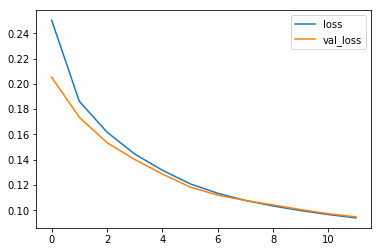

Epoch 13/100
 42/351 [==>...........................] - ETA: 7:20 - loss: 0.0916

Process ForkPoolWorker-262:
Process ForkPoolWorker-263:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/multiprocess

KeyboardInterrupt: ignored

In [0]:
vocab_paras = [sent_max_en, vocab_size_en, 
               sent_max_it, vocab_size_it]
training_generator = DataGenerator(len(en_train), vocab_paras,
                                   en_train, it_train, 
                                   batch_size=512,shuffle=True)
validation_generator = DataGenerator(len(en_valid), vocab_paras,
                                     en_valid, it_valid, 
                                     batch_size=64, shuffle=True)
# training
check_path = 'gdrive/My Drive/Colab Notebooks/Models/Many2many/checkpoint/'
checkpoint = ModelCheckpoint(check_path + 'weights.{epoch:03d}-{val_loss:.6f}.hdf5',
                            monitor='val_loss')

if len(os.listdir(check_path)) != 0:
    list_of_files = glob.glob(check_path + '*') # * means all if need specific format then *.csv
    latest_file = max(list_of_files, key=os.path.getctime)
    # Load model:
    model = load_model(latest_file)
    # Finding the epoch index from which we are resuming
    initial_epoch = get_init_epoch(latest_file)
else:
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    initial_epoch = 0
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    use_multiprocessing=True,
                    callbacks=[plot_losses, checkpoint],
                    epochs=100, 
                    initial_epoch=initial_epoch)

It can be seen from the above figure, validation loss is not bad. However if we sample the sentences it's not good.

In [0]:
model.save(root_path + 's2s.h5')

In [0]:
# encoder model is separated from the complex model
encoder_model = Model(encoder_inputs, encoder_states)


# decoder model is also just LSTM + Dense
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [0]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, vocab_size_it))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, char_to_ix_it['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = ix_to_char_it[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > sent_max_it):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, vocab_size_it))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [0]:
indices_test = np.arange(df1.shape[0])
indices_test_30 = indices_test[10:300:10]

X_1_test = np.zeros((len(indices_test_30), sent_max_en, vocab_size_en))

# Using training data to check the result
for i, idd in enumerate(indices_test_30):
    for j, charr in enumerate(data_en[idd]):
        X_1_test[i, j, char_to_ix_en[charr]] = 1
    
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = X_1_test[seq_index: seq_index + 1]
    print(input_seq.shape)
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence: ', data_en[seq_index])
    print('What it should be: ', data_it[seq_index][:-1])
    print('Decoded sentence: ', decoded_sentence)

(1, 262, 87)
-
Input sentence:  I didn't want to go, but I needed to.
What it should be:  	Io non volevo andare, però dovevo.
Decoded sentence:  Si è andato a casa.

(1, 262, 87)
-
Input sentence:  Tom had his wallet stolen while he was in Boston.
What it should be:  	A Tom hanno rubato il portafoglio mentre era a Boston.
Decoded sentence:  Tom ha comprato un conto di Mary.

(1, 262, 87)
-
Input sentence:  Tom is not good enough.
What it should be:  	Tom non è abbastanza bravo.
Decoded sentence:  Tom è in casa.

(1, 262, 87)
-
Input sentence:  Take my hand.
What it should be:  	Prendete la mia mano.
Decoded sentence:  Tom è un po' stanco.

(1, 262, 87)
-
Input sentence:  He struck at me with a stick.
What it should be:  	Mi colpì con un bastone.
Decoded sentence:  Non sono stato a Boston.

(1, 262, 87)
-
Input sentence:  You look surprised.
What it should be:  	Sembrate sorprese.
Decoded sentence:  Tom ha detto che non lo farà da sola.

(1, 262, 87)
-
Input sentence:  Tom buttered his 

In [0]:
indices_test = np.arange(df0.shape[0])
indices_test_30 = indices_test[100:300:10]

X_1_test = np.zeros((len(indices_test_30), sent_max_en, vocab_size_en))


data_en_test = list(map(lambda x: x.lower(), list(df0[0])))
data_it_test = list(map(lambda x: x.lower(), list(df0[1])))
# Generate
for i, idd in enumerate(indices_test_30):
    for j, charr in enumerate(data_en_test[idd]):
        X_1_test[i, j, char_to_ix_en[charr]] = 1
    
for seq_index in range(10):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = X_1_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence: ', data_en[seq_index])
    print('What it should be: ', data_it[seq_index][:-1])
    print('Decoded sentence: ', decoded_sentence)

-
Input sentence:  I didn't want to go, but I needed to.
What it should be:  	Io non volevo andare, però dovevo.
Decoded sentence:  La sua casa è adesso.

-
Input sentence:  Tom had his wallet stolen while he was in Boston.
What it should be:  	A Tom hanno rubato il portafoglio mentre era a Boston.
Decoded sentence:  La vostra scuola.

-
Input sentence:  Tom is not good enough.
What it should be:  	Tom non è abbastanza bravo.
Decoded sentence:  La vostra scuola.

-
Input sentence:  Take my hand.
What it should be:  	Prendete la mia mano.
Decoded sentence:  Come sono presto?

-
Input sentence:  He struck at me with a stick.
What it should be:  	Mi colpì con un bastone.
Decoded sentence:  Come sembra interessante.

-
Input sentence:  You look surprised.
What it should be:  	Sembrate sorprese.
Decoded sentence:  Segui a casa.

-
Input sentence:  Tom buttered his toast.
What it should be:  	Tom ha imburrato il suo toast.
Decoded sentence:  La sua casa è adesso.

-
Input sentence:  I respec